In [1]:
import os
import numpy as np
from sklearn.svm import LinearSVC

import glob
import pickle
import h5py
import itertools
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# First import test data
with h5py.File('../data/pcr_dataset_test.hdf5', 'r') as myfile:
    test_dataset = {}
    test_dataset['spindle_firing'] = myfile['spindle_firing'][()]
    test_dataset['muscle_coords'] = myfile['muscle_coords'][()]
    test_dataset['endeffector_coords'] = myfile['endeffector_coords'][()]
    test_dataset['joint_coords'] = myfile['joint_coords'][()]
    test_dataset['label'] = myfile['label'][()]
    test_dataset['plane'] = myfile['plane'][()]
    test_dataset['size'] = myfile['size'][()]
    test_dataset['speed'] = myfile['speed'][()]

**Sanity Checks**

In [ ]:
labels = range(1, 21)
classifiers_list = []
for i, j in itertools.combinations(labels, 2):
    filename = f'./ovo_results/spindle_firing_full_variability_{i}_{j}.p'
    classifiers, scores, _ = pickle.load(open(filename, 'rb'))['spindle_firing']
    classifiers_list.append(([i, j], classifiers[np.argmax(scores)], max(scores)))

In [ ]:
# Test whether the training was successful or not
# Validation accuracy and test accuracy must be close enough!
pair, classifiers, val_accuracy = zip(*classifiers_list)

In [ ]:
test_accuracy = []
for i in range(len(pair)):
    mypair = pair[i]
    binary_valid_idx = [x in mypair for x in test_dataset['label']]
    binary_valid_data = test_dataset['spindle_firing'][binary_valid_idx]
    binary_valid_labels = test_dataset['label'][binary_valid_idx]
    acc = classifiers[i].score(binary_valid_data.reshape(-1, 25*320), binary_valid_labels)
    test_accuracy.append(acc)

In [ ]:
plt.plot(test_accuracy)
plt.plot(val_accuracy)

In [ ]:
# given class label, go through the confidence scores, take mean and sd, plot
mytestclassifier = classifiers[0]
confidences = mytestclassifier.decision_function(test_data.reshape(-1, 25*320))
max_idx = max(np.unique(test_labels, return_counts=True)[1])
confidences_list = []
for label in range(1, 21):
    valid_idx = test_labels == label
    confidences_list.append(confidences[valid_idx])

In [ ]:
plt.boxplot(confidences_list)
mylabels = ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
plt.xticks(np.arange(1, 21), mylabels); plt.show()

**Multiclass Classification**

In [ ]:
# Making decisions, given predictions and confidences:
# Reimplemented from sklearn
def decision_function(predictions, confidences, n_classes):
    n_samples = predictions.shape[0]
    votes = np.zeros((n_samples, n_classes))
    sum_of_confidences = np.zeros((n_samples, n_classes))

    k = 0
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            sum_of_confidences[:, i] -= confidences[:, k]
            sum_of_confidences[:, j] += confidences[:, k]
            votes[predictions[:, k] == i+1, i] += 1
            votes[predictions[:, k] == j+1, j] += 1
            k += 1

    max_confidences = sum_of_confidences.max()
    min_confidences = sum_of_confidences.min()

    if max_confidences == min_confidences:
        return votes

    # Scale the sum_of_confidences to (-0.5, 0.5) and add it with votes.
    # The motivation is to use confidence levels as a way to break ties in
    # the votes without switching any decision made based on a difference
    # of 1 vote.
    eps = np.finfo(sum_of_confidences.dtype).eps
    max_abs_confidence = max(abs(max_confidences), abs(min_confidences))
    scale = (0.5 - eps) / max_abs_confidence
    
    return votes + sum_of_confidences * scale

def gather_accuracies(classifiers, test_data, test_labels):    
    num_samples = test_data.shape[0]
    n_classifiers = len(classifiers)
    n_classes = 20

    predictions = np.zeros((num_samples, n_classifiers))
    confidences = np.zeros((num_samples, n_classifiers))

    for i in range(n_classifiers):
        predictions[:, i] = classifiers[i].predict(test_data)
        confidences[:, i] = classifiers[i].decision_function(test_data)

    decisions = decision_function(predictions, confidences, n_classes)
    decisions = np.argmax(decisions, axis=1)

    accuracy = np.sum(test_labels-1 == decisions)/num_samples
    
    return (accuracy, test_labels-1, decisions)

**Full Variability Datasets**

In [ ]:
def multiclass_performance(input_type):    
    # Collect classifiers given input type
    labels = range(1, 21)
    classifiers_list = []
    for i, j in itertools.combinations(labels, 2):
        filename = f'./ovo_results/{input_type}_full_variability_{i}_{j}.p'
        classifiers, scores, _ = pickle.load(open(filename, 'rb'))[input_type]
        classifiers_list.append(([i, j], classifiers[np.argmax(scores)], max(scores)))
    
    mytest_data = test_dataset[input_type]
    mytest_labels = test_dataset['label']
    
    pair, classifiers, score = zip(*classifiers_list)
    
    _, ninputs, ntime = mytest_data.shape
    binary_accuracies = []
    for i in range(len(pair)):
        mypair = pair[i]
        binary_valid_idx = [x in mypair for x in mytest_labels]
        binary_valid_data = mytest_data[binary_valid_idx]
        binary_valid_labels = mytest_labels[binary_valid_idx]
        acc = classifiers[i].score(binary_valid_data.reshape(-1, ninputs*ntime), binary_valid_labels)
        binary_accuracies.append(acc)

    accuracy_decisions = gather_accuracies(classifiers, mytest_data.reshape(-1, ninputs*ntime), mytest_labels)

    return binary_accuracies, accuracy_decisions[0]

In [ ]:
results = []
inputs = ['endeffector_coords', 'joint_coords', 'muscle_coords', 'spindle_firing']
for input_type in inputs:
    bin_acc, acc_dec = multiclass_performance(input_type)
    myresults = {
        'input_type': input_type,
        'suppressed_var': 'None',
        'suppressed_val': 'None',
        'binary_acc': bin_acc,
        'accuracy': acc_dec
    }
    results.append(copy.copy(myresults))

**Latent Variable Suppressed Datasets**

In [ ]:
def multiclass_performance_suppressed(input_type, suppressed_var, test_dataset):
    '''
    Arguments
    ---------
    input_type : type of input used for classifier
    suppressed_var : a tuple, whose first element tells us about how to form the classifier list
                     and second element tells us how to obtain test dataset
    test_dataset : containing all necessary information to evaluate the classifiers
    
    '''
    
    # Collect classifiers given input type and suppressed variable key
    labels = range(1, 21)
    classifiers_list = []
    for i, j in itertools.combinations(labels, 2):
        filename = f'./ovo_results/{input_type}_suppressed_{i}_{j}.p'
        classifiers, scores, _ = pickle.load(open(filename, 'rb'))[suppressed_var[0]]
        classifiers_list.append(([i, j], classifiers[np.argmax(scores)], max(scores)))
    
    # Make test data given what latent variables were suppressed
    latent_var, latent_val = suppressed_var[1] # Can be lists
    if type(latent_var) is list:
        valid_idx = np.logical_and(
            *[test_dataset[latent_var[i]] == latent_val[i] for i in range(len(latent_var))])
    else:
        valid_idx = test_dataset[latent_var] == latent_val
    
    mytest_data = test_dataset[input_type][valid_idx]
    mytest_labels = test_dataset['label'][valid_idx]
    
    pair, classifiers, score = zip(*classifiers_list)
    
    _, ninputs, ntime = mytest_data.shape
    binary_accuracies = []
    for i in range(len(pair)):
        mypair = pair[i]
        binary_valid_idx = [x in mypair for x in mytest_labels]
        binary_valid_data = mytest_data[binary_valid_idx]
        binary_valid_labels = mytest_labels[binary_valid_idx]
        acc = classifiers[i].score(binary_valid_data.reshape(-1, ninputs*ntime), binary_valid_labels)
        binary_accuracies.append(acc)

    accuracy_decisions = gather_accuracies(classifiers, mytest_data.reshape(-1, ninputs*ntime), mytest_labels)

    return binary_accuracies, accuracy_decisions[0]

In [ ]:
latent_variable_keys = {
    'horizontal': ('plane', b'horizontal'), 'vertical': ('plane', b'vertical'),
    'size1': ('size', 0.7), 'size2': ('size', 1), 'size3': ('size', 1.3),
    'speed1': ('speed', 0.8), 'speed2': ('speed', 1.0), 'speed3': ('speed', 1.2), 'speed4': ('speed', 1.4),
    'sp1': (['size', 'plane'], [0.7, b'horizontal']),
    'sp2': (['size', 'plane'], [0.7, b'vertical']),
    'sp3': (['size', 'plane'], [1, b'horizontal']),
    'sp4': (['size', 'plane'], [1, b'vertical']),
    'sp5': (['size', 'plane'], [1.3, b'horizontal']),
    'sp6': (['size', 'plane'], [1.3, b'vertical'])
}

In [ ]:
for i, j in itertools.product(inputs, latent_variable_keys):
    bin_acc, acc_dec = multiclass_performance_suppressed(i, (j, latent_variable_keys[j]), test_dataset)
    myresults = {
        'input_type': i, 
        'suppressed_var': latent_variable_keys[j][0],
        'suppressed_val': latent_variable_keys[j][1],
        'binary_acc': bin_acc,
        'accuracy': acc_dec
    }
    results.append(copy.copy(myresults))

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)

def replace(df, col, key, val):
    m = [v == key for v in df[col]]
    df.loc[m, col] = val
    
replace(results_df, 'suppressed_var', ['size', 'plane'], 'size_plane')

In [ ]:
results_df.to_pickle('./svm_results.p')

**Plotting**

In [2]:
results_df = pickle.load(open('./svm_results.p', 'rb'))

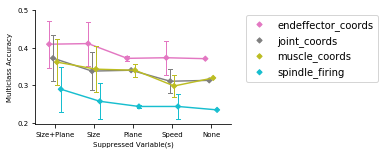

In [4]:
plt.figure(figsize=[3.5, 2.1])
with plt.rc_context({'lines.linewidth': 0.8}):
    sns.pointplot(x='suppressed_var', y='accuracy', hue='input_type', data=results_df, 
              order=['size_plane', 'size', 'plane', 'speed', 'None'], dodge=0.3, errwidth=1, 
              ci='sd', capsize=0.1, markers='D', palette=['C6', 'C7', 'C8', 'C9'])
sns.despine()
plt.xticks([0, 1, 2, 3, 4], ['Size+Plane', 'Size', 'Plane', 'Speed', 'None'], fontsize=7);
plt.yticks([0.2, 0.3, 0.4, 0.5], [0.2, 0.3, 0.4, 0.5], fontsize=7)
plt.xlabel('Suppressed Variable(s)', fontsize=7)
plt.ylabel('Multiclass Accuracy', fontsize=7)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

---